# Results (tables, figs)

In [1]:
# HIDE CODE


import os, sys
sys.path.insert(0, './')
from analysis.eval import sparse_score
from utils.plotting import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

In [3]:
root = 'Dropbox/git/PoissonVAE'  # base directory for the project (update to match your setup)
root = add_home(f"{root}/results")  # contains processed results, saved as DataFrames

from analysis.stats import ttest
from analysis.final import sort_fits, analyze_fits, add_nelbo_diff
from figures.point import nelbo_point, get_palette, show_palette
from figures.table import table_entry_active, table_entry_knn, table_entry_shatter, table_entry_loss
from base.utils_model import load_quick

## Table 2: active neurons

### Load dfs

In [4]:
df_main = pd.read_pickle(pjoin(root, 'df_main.df'))

selected_models = [
    'poisson',
    'gaussian',
    'laplace',
]
df = df_main.loc[
    (df_main['method'] == 'mc') &
    (df_main['type'].isin(selected_models))
]

df.shape

(90, 17)

In [5]:
df.pivot_table(
    values='active',
    index='type',
    columns=['dataset', 'enc_type'],
)

dataset  CIFAR10-PATCHES               DOVES               MNIST          
enc_type            conv       lin      conv       lin      conv       lin
type                                                                      
gaussian        0.246094  0.105469  0.246094  0.217578  0.031250  0.027344
laplace         0.230469  0.192969  0.221875  0.187500  0.033984  0.027344
poisson         0.928125  0.999219  0.819141  0.983984  0.426172  0.536719

### t-test

In [6]:
df_agg, df_ttest = ttest(
    df=df,
    value='active',
    by=['dataset', 'enc_type', 'type'],
    test_conds=[
        ('poisson', m) for m in
        df['type'].unique()
        if m != 'poisson'],
    method='fdr_bh',
    alpha=0.01,
)

In [7]:
df_ttest

,dataset,enc_type,cond1,cond2,t,pvals,pvals_fdr_bh,reject
0,CIFAR10-PATCHES,conv,poisson,gaussian,61.982740,4.058027e-07,4.869632e-07,True
1,CIFAR10-PATCHES,conv,poisson,laplace,63.402735,3.706802e-07,4.869632e-07,True
2,CIFAR10-PATCHES,lin,poisson,gaussian,407.662481,2.172355e-10,1.303413e-09,True
3,CIFAR10-PATCHES,lin,poisson,laplace,842.624472,1.190175e-11,1.428210e-10,True
4,DOVES,conv,poisson,gaussian,58.147482,5.238076e-07,5.714265e-07,True
5,DOVES,conv,poisson,laplace,56.552108,5.853981e-07,5.853981e-07,True
6,DOVES,lin,poisson,gaussian,255.430643,1.409337e-09,2.818674e-09,True
7,DOVES,lin,poisson,laplace,300.634149,7.344563e-10,2.818674e-09,True
8,MNIST,conv,poisson,gaussian,141.568316,1.493284e-08,2.559916e-08,True
9,MNIST,conv,poisson,laplace,134.165143,1.851107e-08,2.776661e-08,True


In [8]:
df_ttest.pivot(index='cond2', columns=['dataset', 'enc_type'], values='reject')

dataset  CIFAR10-PATCHES       DOVES       MNIST      
enc_type            conv   lin  conv   lin  conv   lin
cond2                                                 
gaussian            True  True  True  True  True  True
laplace             True  True  True  True  True  True

### Confidence intervals (99%)

In [10]:
%%time

for ds in ['DOVES', 'CIFAR10-PATCHES', 'MNIST']:
    table = table_entry_active(ds, df_agg, fmt='0.3f')
    print(f"——— dataset: {ds} ———\n")
    print(table)
    print('\n\n\n')

——— dataset: DOVES ———

\begin{tabularx}{34mm}{CC}
    \entry{0.984}{.011} & \entry{0.819}{.041} \\ 
    \entry{0.188}{.000} & \entry{0.222}{.003} \\ 
    \entry{0.218}{.003} & \entry{0.246}{.000}
\end{tabularx}

——— dataset: CIFAR10-PATCHES ———

\begin{tabularx}{34mm}{CC}
    \entry{0.999}{.002} & \entry{0.928}{.045} \\ 
    \entry{0.193}{.003} & \entry{0.230}{.000} \\ 
    \entry{0.105}{.008} & \entry{0.246}{.000}
\end{tabularx}

——— dataset: MNIST ———

\begin{tabularx}{34mm}{CC}
    \entry{0.537}{.008} & \entry{0.426}{.011} \\ 
    \entry{0.027}{.000} & \entry{0.034}{.002} \\ 
    \entry{0.027}{.000} & \entry{0.031}{.000}
\end{tabularx}

CPU times: user 2.18 s, sys: 390 ms, total: 2.57 s
Wall time: 2.56 s


## Tables 3 & 5: geometry of representations

### Load dfs

In [11]:
df_knn = pd.read_pickle(pjoin(root, 'df_knn.df'))
df_shatter = pd.read_pickle(pjoin(root, 'df_shatter.df'))

### Shattering dim

#### t-test

In [12]:
selected_models = [
    'poisson', 'categorical', 'laplace',
    'gaussian', 'gaussian-relu', 'gaussian-exp',
]
df_selected = df_shatter.loc[df_shatter['n_dims'].isin([10, 50, 100])].copy()
df_selected = df_selected.loc[df_selected['type'].isin(selected_models)]

In [13]:
df_agg, df_ttest = ttest(
    value='accuracy',
    df=df_selected,
    by=['n_dims', 'type'],
    test_conds=[
        ('poisson', m) for m in
        df_selected['type'].unique()
        if m != 'poisson'],
    method='fdr_bh',
    alpha=0.01,
)

In [14]:
df_ttest

,n_dims,cond1,cond2,t,pvals,pvals_fdr_bh,reject
0,10,poisson,categorical,0.662967,5.074730e-01,5.074730e-01,False
1,10,poisson,gaussian,16.687499,1.236669e-56,1.426926e-56,True
2,10,poisson,gaussian-exp,28.113196,2.300337e-135,3.136824e-135,True
3,10,poisson,gaussian-relu,15.893258,5.624889e-52,6.026667e-52,True
4,10,poisson,laplace,19.559841,1.331953e-74,1.664942e-74,True
5,50,poisson,categorical,42.717303,3.587684e-247,5.381527e-247,True
6,50,poisson,gaussian,119.982773,0.000000e+00,0.000000e+00,True
7,50,poisson,gaussian-exp,111.222322,0.000000e+00,0.000000e+00,True
8,50,poisson,gaussian-relu,109.848941,0.000000e+00,0.000000e+00,True
9,50,poisson,laplace,100.845083,0.000000e+00,0.000000e+00,True


In [15]:
df_ttest.pivot(index='cond2', columns='n_dims', values='reject')

n_dims,10,50,100
cond2,,,
categorical,False,True,True
gaussian,True,True,True
gaussian-exp,True,True,True
gaussian-relu,True,True,True
laplace,True,True,True


#### Confidence intervals (99%)

In [16]:
%%time

for dim in [10, 50, 100]:
    table = table_entry_shatter(dim, df_agg, n_resamples=int(1e5), fmt='0.3f')
    print(f"——— dim: {dim} ———\n")
    print(table)
    print('\n\n\n')

——— dim: 10 ———

\begin{tabular}{c}
    \entry{0.797}{.010} \\ 
    \entry{0.795}{.007} \\ 
    \entry{0.751}{.009} \\ 
    \entry{0.758}{.008} \\ 
    \entry{0.762}{.008} \\ 
    \entry{0.737}{.009}
\end{tabular}

——— dim: 50 ———

\begin{tabular}{c}
    \entry{0.935}{.004} \\ 
    \entry{0.899}{.004} \\ 
    \entry{0.770}{.008} \\ 
    \entry{0.743}{.008} \\ 
    \entry{0.786}{.007} \\ 
    \entry{0.762}{.008}
\end{tabular}

——— dim: 100 ———

\begin{tabular}{c}
    \entry{0.949}{.003} \\ 
    \entry{0.884}{.005} \\ 
    \entry{0.767}{.008} \\ 
    \entry{0.763}{.007} \\ 
    \entry{0.818}{.007} \\ 
    \entry{0.793}{.007}
\end{tabular}

CPU times: user 40.1 s, sys: 9.98 s, total: 50 s
Wall time: 50 s


### KNN

#### t-test

In [17]:
selected_models = [
    'poisson', 'categorical', 'laplace',
    'gaussian', 'gaussian-relu', 'gaussian-exp',
]
df_selected = df_knn.loc[df_knn['n_dims'].isin([10, 50, 100])].copy()
df_selected = df_selected.loc[df_selected['type'].isin(selected_models)]

In [18]:
df_agg, df_ttest = ttest(
    value='accuracy',
    df=df_selected,
    by=['n_dims', 'size', 'type'],
    test_conds=[
        ('poisson', m) for m in
        df_selected['type'].unique()
        if m != 'poisson'],
    method='fdr_bh',
    alpha=0.01,
)

In [19]:
df_ttest

,n_dims,size,cond1,cond2,t,pvals,pvals_fdr_bh,reject
0,10,200,poisson,categorical,169.881202,0.000000,0.000000,True
1,10,200,poisson,gaussian,182.398750,0.000000,0.000000,True
2,10,200,poisson,gaussian-exp,165.188618,0.000000,0.000000,True
3,10,200,poisson,gaussian-relu,145.069923,0.000000,0.000000,True
4,10,200,poisson,laplace,82.033128,0.000000,0.000000,True
5,10,1000,poisson,categorical,240.189356,0.000000,0.000000,True
6,10,1000,poisson,gaussian,221.416368,0.000000,0.000000,True
7,10,1000,poisson,gaussian-exp,203.872618,0.000000,0.000000,True
8,10,1000,poisson,gaussian-relu,161.395089,0.000000,0.000000,True
9,10,1000,poisson,laplace,132.399649,0.000000,0.000000,True


In [20]:
df_ttest.pivot(index=['n_dims', 'cond2'], columns='size', values='reject')

size                  200   1000   5000
n_dims cond2                           
10     categorical    True  True   True
       gaussian       True  True   True
       gaussian-exp   True  True   True
       gaussian-relu  True  True   True
       laplace        True  True  False
50     categorical    True  True   True
       gaussian       True  True   True
       gaussian-exp   True  True   True
       gaussian-relu  True  True   True
       laplace        True  True   True
100    categorical    True  True   True
       gaussian       True  True   True
       gaussian-exp   True  True   True
       gaussian-relu  True  True  False
       laplace        True  True  False

#### Confidence intervals (99%)

In [21]:
%%time

for dim in [10, 50, 100]:
    table = table_entry_knn(dim, df_agg, n_resamples=int(1e5), fmt='0.3f')
    print(f"——— dim: {dim} ———\n")
    print(table)
    print('\n\n\n')

——— dim: 10 ———

\begin{tabularx}{65mm}{CCC}
    \entry{0.815}{.002} & \entry{0.919}{.001} & \entry{0.946}{.019} \\ 
    \entry{0.705}{.003} & \entry{0.800}{.002} & \entry{0.853}{.045} \\ 
    \entry{0.757}{.003} & \entry{0.869}{.002} & \entry{0.924}{.032} \\ 
    \entry{0.673}{.003} & \entry{0.813}{.002} & \entry{0.891}{.037} \\ 
    \entry{0.694}{.004} & \entry{0.817}{.003} & \entry{0.877}{.051} \\ 
    \entry{0.642}{.004} & \entry{0.784}{.002} & \entry{0.863}{.037}
\end{tabularx}

——— dim: 50 ———

\begin{tabularx}{65mm}{CCC}
    \entry{0.825}{.002} & \entry{0.927}{.001} & \entry{0.957}{.006} \\ 
    \entry{0.770}{.002} & \entry{0.880}{.001} & \entry{0.920}{.010} \\ 
    \entry{0.710}{.004} & \entry{0.836}{.003} & \entry{0.902}{.043} \\ 
    \entry{0.604}{.003} & \entry{0.746}{.002} & \entry{0.837}{.026} \\ 
    \entry{0.710}{.003} & \entry{0.844}{.002} & \entry{0.904}{.030} \\ 
    \entry{0.694}{.003} & \entry{0.836}{.002} & \entry{0.906}{.031}
\end{tabularx}

——— dim: 100 ———

\begin{tabularx}{65mm}{CCC}
    \entry{0.807}{.002} & \entry{0.925}{.001} & \entry{0.958}{.015} \\ 
    \entry{0.753}{.002} & \entry{0.876}{.001} & \entry{0.925}{.006} \\ 
    \entry{0.701}{.004} & \entry{0.830}{.003} & \entry{0.896}{.053} \\ 
    \entry{0.636}{.004} & \entry{0.789}{.002} & \entry{0.875}{.027} \\ 
    \entry{0.757}{.003} & \entry{0.881}{.001} & \entry{0.933}{.021} \\ 
    \entry{0.695}{.004} & \entry{0.846}{.002} & \entry{0.918}{.027}
\end{tabularx}

CPU times: user 2min 37s, sys: 39 s, total: 3min 16s
Wall time: 3min 16s


## Table 4: negative ELBO

### Load df

In [22]:
df = pjoin(root, 'df_main.df')
df = pd.read_pickle(df)

### t-test

In [23]:
group_cols = ['type', 'dataset', 'enc_type', 'method']

df_agg, df_ttest = ttest(
    df=df,
    value='nelbo',
    by=group_cols,
    test_conds=[('exact', 'mc')]
)

In [24]:
df_ttest

,type,dataset,enc_type,cond1,cond2,t,pvals,pvals_fdr_bh,reject
0,categorical,CIFAR10-PATCHES,conv,exact,mc,29.741441,7.610919e-06,3.653241e-05,True
1,categorical,CIFAR10-PATCHES,lin,exact,mc,107.020257,4.571246e-08,6.433598e-07,True
2,categorical,DOVES,conv,exact,mc,76.319655,1.766480e-07,1.326846e-06,True
3,categorical,DOVES,lin,exact,mc,102.837428,5.361332e-08,6.433598e-07,True
4,categorical,MNIST,conv,exact,mc,-0.754298,5.293873e-01,5.524041e-01,False
5,categorical,MNIST,lin,exact,mc,72.149197,2.211410e-07,1.326846e-06,True
6,gaussian,CIFAR10-PATCHES,conv,exact,mc,-1.736704,1.574435e-01,1.889322e-01,False
7,gaussian,CIFAR10-PATCHES,lin,exact,mc,-0.425670,6.922524e-01,6.922524e-01,False
8,gaussian,DOVES,conv,exact,mc,-2.090717,1.047458e-01,1.396611e-01,False
9,gaussian,DOVES,lin,exact,mc,1.843652,1.390086e-01,1.755898e-01,False


In [25]:
df_ttest.pivot(values='reject', index='type', columns=['dataset', 'enc_type'])

dataset     CIFAR10-PATCHES         DOVES         MNIST       
enc_type               conv    lin   conv    lin   conv    lin
type                                                          
categorical            True   True   True   True  False   True
gaussian              False  False  False  False   True   True
laplace                True  False  False  False  False  False
poisson                True   True   True  False   True   True

### Confidence intervals (99%)

In [26]:
for model in ['poisson', 'gaussian', 'categorical', 'laplace']:
    table = table_entry_loss(model, df_agg)
    print(f"——— model: {model} ———\n")
    print(table)
    print('\n\n\n')

——— model: poisson ———

\begin{tabularx}{34mm}{CC}
    \entry{168.0}{.8} & \entry{162.4}{.2} \\ 
    \entry{167.2}{.1} & \entry{163.4}{.1} \\ 
    \entry{179.3}{.1} & \entry{179.4}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{167.1}{.2} & \entry{162.1}{.1} \\ 
    \entry{167.3}{.1} & \entry{162.9}{.2} \\ 
    \entry{182.3}{.1} & \entry{182.3}{.2}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{41.5}{.1} & \entry{39.7}{.2} \\ 
    \entry{41.7}{.2} & \entry{40.1}{.2} \\ 
    \entry{44.8}{.1} & \entry{44.2}{.1}
\end{tabularx}

——— model: gaussian ———

\begin{tabularx}{34mm}{CC}
    \entry{160.3}{.1} & \entry{154.4}{.1} \\ 
    \entry{160.3}{.1} & \entry{154.4}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{165.9}{.1} & \entry{149.2}{.0} \\ 
    \entry{165.9}{.1} & \entry{149.2}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{40.6}{.1} & \entry{40.0}{.1} \\ 
    \entry{40.7}{.1} & \entry{40.1}{.0}
\end{tabularx}

——— model: categorical ———

\begin{tabularx}{34mm}{CC}
    \entry{174.9}{.1} & \entry{186.3}{.8} \\ 
    \entry{170.5}{.1} & \entry{171.9}{.2} \\ 
    \entry{174.2}{.2} & \entry{181.1}{.3}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{177.1}{.1} & \entry{180.6}{.5} \\ 
    \entry{174.7}{.1} & \entry{176.5}{.1} \\ 
    \entry{180.2}{.0} & \entry{185.6}{.2}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{56.1}{.7} & \entry{59.1}{.0} \\ 
    \entry{39.7}{.2} & \entry{59.1}{.0} \\ 
    \entry{49.3}{.1} & \entry{63.8}{3.4}
\end{tabularx}

——— model: laplace ———

\begin{tabularx}{34mm}{CC}
    \entry{167.3}{.0} & \entry{159.0}{.2} \\ 
    \entry{167.3}{.0} & \entry{159.2}{.2}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{170.1}{.1} & \entry{154.3}{.1} \\ 
    \entry{170.1}{.1} & \entry{154.5}{.1}
\end{tabularx}
&
\begin{tabularx}{34mm}{CC}
    \entry{42.1}{.1} & \entry{41.0}{.0} \\ 
    \entry{42.1}{.0} & \entry{41.0}{.0}
\end{tabularx}

## Figure 4

### Load df

In [27]:
df = pjoin(root, 'df_main.df')
df = pd.read_pickle(df)
df = add_nelbo_diff(df)
df.shape

(150, 9)

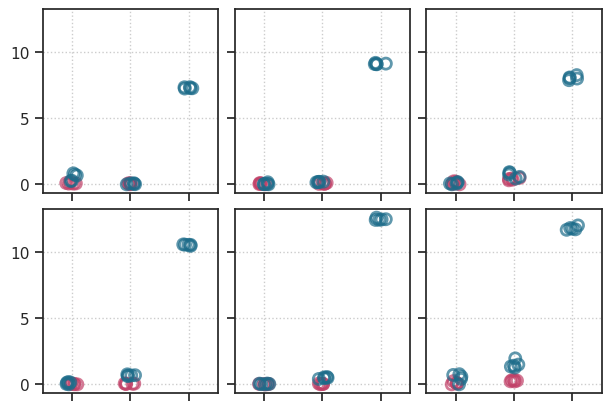

In [28]:
fig, axes = nelbo_point(df, scale=2, alpha=0.6)
# fig.savefig(pjoin(fig_dir, 'nelbo_point.pdf'), **kws_fig)

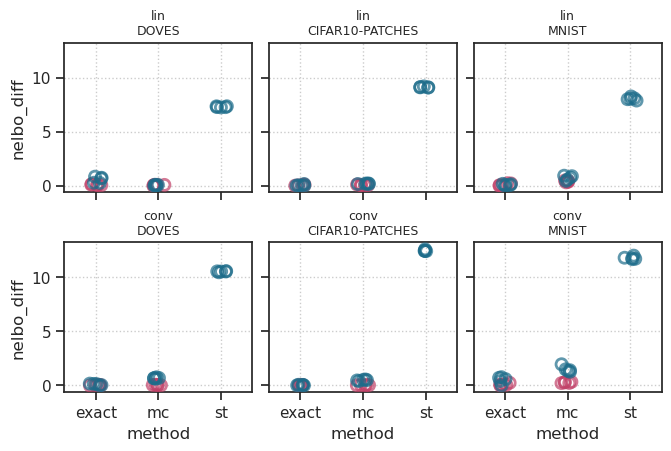

In [29]:
fig, axes = nelbo_point(df, scale=2.2, remove_lbls=False)

In [30]:
df.groupby(['type', 'method']).mean(numeric_only=True)

n_dims  seed    active       nelbo  nelbo_diff
type     method                                                
gaussian exact    512.0   3.0  0.170247  118.394539    0.062021
         mc       512.0   3.0  0.145638  118.430450    0.142867
poisson  exact    512.0   3.0  0.831901  123.472893    0.216889
         mc       512.0   3.0  0.782227  123.759293    0.599133
         st       512.0   3.0  0.742188  135.367767    9.887917

## Figure 3

In [31]:
# HIDE CODE


from matplotlib.collections import LineCollection


def _get_df2p(dfs):
    
    # mse scores
    df_mse = dfs['main'].copy()
    df_mse = df_mse.loc[
        (df_mse['enc_type'] == 'conv') &
        (df_mse['dataset'] == 'DOVES') &
        (df_mse['method'] == 'mc')
    ].reset_index(drop=True)
    
    # lifetime scores
    df_sprs = dfs['lifetime'].copy()
    df_sprs = df_sprs.loc[
        (df_sprs['enc_type'] == 'conv') &
        (df_sprs['dataset'] == 'DOVES') &
        (df_sprs['method'] == 'mc')
    ].reset_index(drop=True)
    df_sprs = df_sprs.groupby(by=['type', 'seed']).mean(
        numeric_only=True)['lifetime'].reset_index()

    # create df2p
    df2p = collections.defaultdict(list)
    looper = itertools.product(
        df_mse['type'].unique(),
        df_mse['seed'].unique(),
    )
    for mod, s in looper:
        vals = {
            'type': mod,
            'seed': s,
        }
        vals['mse_map'] = df_mse.loc[
            (df_mse['seed'] == s) &
            (df_mse['type'] == mod),
            'mse_map',
        ].item()
        vals['lifetime'] = df_sprs.loc[
            (df_sprs['seed'] == s) &
            (df_sprs['type'] == mod),
            'lifetime',
        ].item()
        for k, v in vals.items():
            df2p[k].append(v)
    df2p = pd.DataFrame(df2p)

    # load lca / ista
    df_sc = dfs['sc'].copy()
    df_sc = df_sc.loc[df_sc['quality'] == 'best']
    df_sc = df_sc[['type', 'seed', 'mse_map', 'lifetime']]

    # add lca / ista
    df2p = pd.concat([
        df2p,
        df_sc,
    ]).reset_index(drop=True)
    
    return df2p


def sigmoid_beta_linear(x):
    L, x0, k, b = [
        0.72930579,
        0.76495883,
        3.39020406,
        0.27468761,
    ]
    y = L / (1 + np.exp(-k*(x / 100 - x0))) + b
    return (y)


def sigmoid_lca_poisson(x):
    L, x0, k, b = [
        2.53656547e+02,
        1.56483081e+00,
        1.84206981e-01,
        -2.52717804e+02,
    ]
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y


# plots part a

def scatter_plot_vae_a():
    fig, ax = create_figure(1, 1, (8, 4.5))
    sns.scatterplot(
        data=df2p.loc[df2p['type'].isin(hue_order)],
        x='mse_map',
        y='lifetime',
        hue='type',
        palette=pal,
        hue_order=hue_order,
        alpha=0.9,
        s=200,
        ax=ax,
    )
    for artist in ax.collections:
        c = artist.get_facecolor()
        artist.set_edgecolor(c)
        artist.set_facecolor('none')
        artist.set_lw(1.8)
    ax.grid()
    
    # add line plot
    xs = np.linspace(0, 245, 10000)
    ys = sigmoid_beta_linear(xs)
    
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(ys.min(), ys.max())
    
    lc = LineCollection(
        segments,
        norm=norm,
        cmap='crest',
        linewidth=3,
        alpha=0.6,
        linestyle='--',
    )
    lc.set_array(ys)
    ax.add_collection(lc)
    
    # add beta crosses
    sns.scatterplot(
        data=df2p_linbeta,
        x='mse_map',
        y='lifetime',
        hue='beta',
        palette=pal_beta,
        legend=True,
        alpha=1.0,
        s=100,
        ax=ax,
    )
    
    # final touch
    ax.autoscale()
    ax.set_ylim(0.3, 1.03)
    ax.set_xlim(right=250)
    ax.set(xlabel='', ylabel='')
    ax.tick_params(axis='both', labelsize=15)
    
    # legend
    sns.move_legend(ax, loc='lower right', fontsize=12.0)
    legend = ax.get_legend()
    legend.set_title('')
    
    for handle in legend.legendHandles:
        handle.set_sizes([handle.get_sizes()[0] * 3.0])
    
    for text in legend.get_texts():
        try:
            float(text.get_text())
        except ValueError:
            continue
    
        b = float(text.get_text())
        text.set_text(r"$\beta = $" + f" {b:0.2f}")
    
    plt.show()

    return fig, ax


# plots part b

def scatter_plot_vae_b():
    fig, ax = create_figure(1, 1, (8, 4.5))
    sns.scatterplot(
        data=df2p.loc[df2p['type'].isin(hue_order)],
        x='mse_map',
        y='lifetime',
        hue='type',
        palette=pal,
        hue_order=hue_order,
        alpha=0.9,
        s=200,
        ax=ax,
    )
    for artist in ax.collections:
        c = artist.get_facecolor()
        artist.set_edgecolor(c)
        artist.set_facecolor('none')
        artist.set_lw(1.8)
    ax.grid()
    
    # add line plot
    xs = np.linspace(37, 115, 10000)
    ys = sigmoid_lca_poisson(xs)
    
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(ys.min(), ys.max())
    
    lc = LineCollection(
        segments,
        norm=norm,
        cmap=sns.cubehelix_palette(as_cmap=True),
        linewidth=3,
        alpha=0.6,
        linestyle='--',
    )
    lc.set_array(ys)
    ax.add_collection(lc)
    
    # add beta crosses
    sns.scatterplot(
        data=df2p_lcs_inf,
        x='mse_map',
        y='lifetime',
        hue='lamb',
        palette=pal_lamb,
        legend=True,
        s=100,
        ax=ax,
    )
    
    # final touch
    ax.autoscale()
    ax.set_ylim(0.6, 1.0)
    ax.set_xlim(right=125)
    ax.set(xlabel='', ylabel='')
    ax.tick_params(axis='both', labelsize=15)
    
    # legend
    sns.move_legend(ax, loc='lower right', fontsize=12.0)
    legend = ax.get_legend()
    legend.set_title('')
    
    for handle in legend.legendHandles:
        handle.set_sizes([handle.get_sizes()[0] * 3.0])
    
    for text in legend.get_texts():
        try:
            float(text.get_text())
        except ValueError:
            continue
    
        b = float(text.get_text())
        msg = f"poisson w/ LCA inference ("
        msg += r"$\beta_\text{LCA} = $" + f" {b:0.1g})"
        text.set_text(msg)
    
    plt.show()

    return fig, ax

### Palette

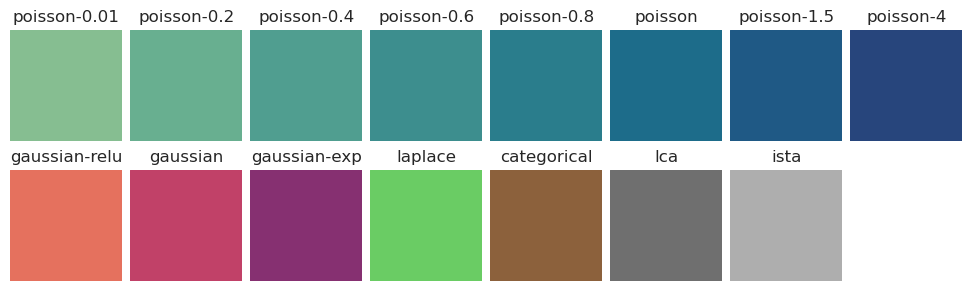

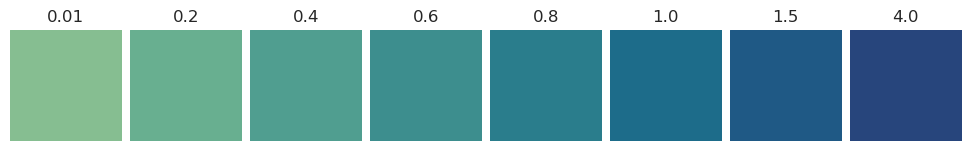

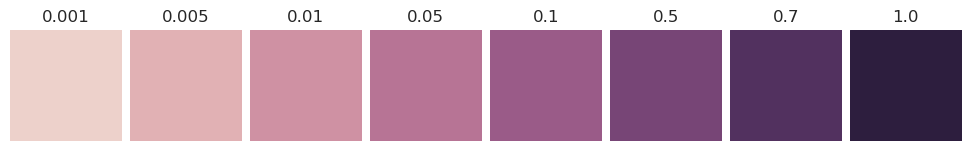

In [32]:
pal, pal_beta, pal_lamb = get_palette()
show_palette(pal)
show_palette(pal_beta)
show_palette(pal_lamb)

### Load dfs

In [33]:
dfs = [
    'main',
    'lifetime',
    'beta_main',
    'beta_lifetime',
]
dfs = {
    k: pd.read_pickle(pjoin(root, f"df_{k}.df")).drop(columns=[
        'checkpoint', 'timestamp', 'n_params',
    ]) for k in dfs
}
dfs['sc'] = pd.read_pickle(pjoin(root, 'df_sc.df'))
print(list(dfs))

['main', 'lifetime', 'beta_main', 'beta_lifetime', 'sc']

In [34]:
df2p_linbeta = pd.read_pickle(pjoin(root, 'df2p_poisson_lin_beta.df'))
df2p_linbeta = df2p_linbeta.groupby(by=['beta']).mean(
    numeric_only=True).reset_index().drop(columns='seed')
df2p_linbeta.shape

(8, 3)

In [35]:
df2p = _get_df2p(dfs)
df2p.shape

(40, 4)

### Fig. 3a

In [36]:
hue_order = [
    'poisson', 'categorical', 'laplace',
    'gaussian', 'gaussian-relu', 'gaussian-exp',
]

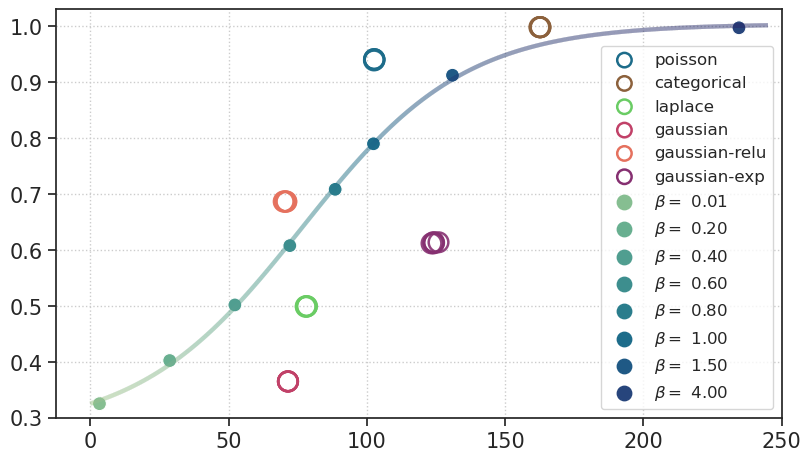

In [ ]:
fig, ax = scatter_plot_vae_a()
# fig.savefig(pjoin(fig_dir, 'rate_dist_vae.pdf'), **kws_fig)

### Fig. 3b

In [38]:
df2p_lcs_inf = pd.read_pickle(pjoin(root, 'df2p_lcs_inf.df'))
df2p_lcs_inf = df2p_lcs_inf.loc[df2p_lcs_inf['vae_source'] == 'poisson']
df2p_lcs_inf.shape

(8, 4)

In [39]:
hue_order = [
    'lca', 'ista', 'poisson',
]

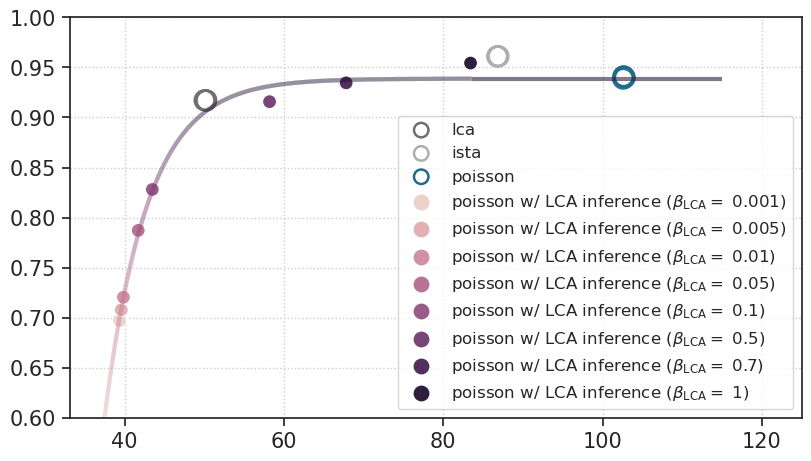

In [40]:
fig, ax = scatter_plot_vae_b()
# fig.savefig(pjoin(fig_dir, 'rate_dist_lca.pdf'), **kws_fig)

## Figure 5

In [41]:
# HIDE CODE


def detect_dead_neurons(tr):
    dead_thres = {
        'poisson': 0.0082,
        'gaussian': 0.09,
        'laplace': 0.08,
    }
    data, loss, etc = tr.validate()

    if tr.model.cfg.type == 'categorical':
        thres = None
        dead = tr.model.find_dead_neurons(1)
    else:
        thres = dead_thres.get(tr.model.cfg.type)
        dead = loss['kl_diag'] < thres
    return data, loss, etc, thres, dead.astype(bool)

In [ ]:
root = 'Dropbox/git/PoissonVAE'  # base directory for the project (update to match your setup)
root = add_home(f"{root}/checkpoints")  # contains model checkpoints

models2load = {
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [43]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 394.2 K

# params: 262.7 K

# params: 394.2 K

# params: 262.7 K

In [44]:
bins = {
    'poisson': np.linspace(0, 111 / 1000, 112),
    'gaussian': np.linspace(0, 80 / 100, 81),
    'laplace': np.linspace(0, 80 / 100, 81),
}
pal = get_palette()[0]

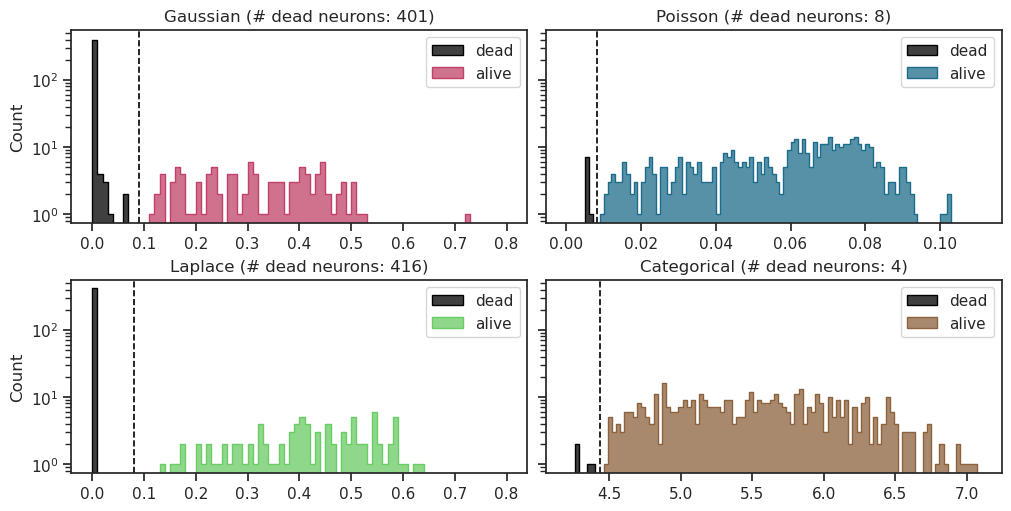

In [45]:
fig, axes = create_figure(2, 2, (10, 5), sharey='all')

for idx, (name, tr) in enumerate(trainers.items()):
    color = pal[name]
    data, loss, etc, thres, dead = detect_dead_neurons(tr)
    ax = axes.flat[idx]
    if name == 'categorical':
        norms = tonp(torch.linalg.vector_norm(
        tr.model.fc_dec.weight.data, dim=0))
        thres = 4.435
        dead = norms < thres

        sns.histplot(norms[dead], bins=np.linspace(4.2, 7.1, 101), color='k', label='dead', element='step', ax=ax)
        sns.histplot(norms[~dead], bins=np.linspace(4.2, 7.1, 101), color=color, label='alive', element='step', ax=ax)

    else:
        sns.histplot(loss['kl_diag'][dead], bins=bins[name], color='k', label='dead', element='step', ax=ax)
        sns.histplot(loss['kl_diag'][~dead], bins=bins[name], color=color, label='alive', element='step', ax=ax)

    ax.axvline(thres, color='k', ls='--', lw=1.2)

    ax.locator_params(axis='x', nbins=11)
    ax.set_title(f"{name.capitalize()} (# dead neurons: {dead.sum()})")
    ax.set_yscale('log')
axes[0, 1].set(ylabel='')
axes[1, 1].set(ylabel='')
add_legend(axes)
plt.show()

In [46]:
# fig.savefig(pjoin(fig_dir, 'dead_kl_gap.pdf'), **kws_fig)